# Setting up our Notebook

In [1]:
# Things to import

# Standard data, plotting, and mathematical tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# MLP
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from keras import utils

# Grid Search
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

# Confusion Matrix
import seaborn as sns

Using TensorFlow backend.


# Importing the data

In [2]:
# Importing the data

dfs=['Non-Scaled TA Features 1H for BTC.csv']

# Multi-Layer Perceptron

## BTC

### Getting the train/test data

In [1]:
# Defining a function to create PCA matrices

def PCA_creation_train_val_test(no_components, X_train, X_val, X_test):
    
    # Scaling the data with our X_train matrix
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)
    
    # Fitting the PCA to our X_train matrix
    pca=PCA(n_components=no_components)
    X_train=pca.fit_transform(X_train)

    # Scaling the X_val and X_test 
    X_val=scaler.transform(X_val)
    X_test=scaler.transform(X_test)

    # Transforming the X_val and X_test
    X_val=pca.transform(X_val)
    X_test=pca.transform(X_test)
    
    return X_train, X_val, X_test

In [5]:
# Train and test splitting and scaling
X=pd.read_csv(dfs[0])
X=X.dropna()
y=X['Label']
X=X.drop('Label', axis=1)
X=X.drop('Unnamed: 0', axis=1)
X=X.drop('Percent Change', axis=1)

num_classes=2 

# split into train and test
X_train, X_val, y_train, y_val = train_test_split(X, y,test_size=0.1, random_state=100, shuffle=True)
X_train, X_test, y_train, y_test=train_test_split(X_train, y_train, test_size=0.1, random_state=100, shuffle=True)


X_train, X_val, X_test=PCA_creation_train_test_val(20, X_train, X_val, X_test)


y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)
y_val = utils.to_categorical(y_val, num_classes)

### Grid Search for Optimizer and parameters

In [6]:
# Function to create the model for Keras wrapper to scikit learn

# We will optimize the number of layers, the activation function, the neurons per layer, 
# and the optimizer (learning rate, decay steps, and decay rate)

def create_mlp_model(activ_function='relu', neurons=50, dropout_rate=0.1, num_layers=1, 
                     optimizer='adam',init_lr=1e-1, decay_steps=5000, decay_rates=0.1):
    
    # Create the model and run through the number of layers
    model = keras.Sequential()
    
    if num_layers==1:
        # First layer
        model.add(keras.layers.Dense(neurons, activation=activ_function, input_shape=(X_train.shape[1],)))
        model.add(keras.layers.Dropout(dropout_rate))
        
    if num_layers==2:
        # First layer
        model.add(keras.layers.Dense(neurons, activation=activ_function, input_shape=(X_train.shape[1],)))
        model.add(keras.layers.Dropout(dropout_rate))
        # Second layer
        model.add(keras.layers.Dense(neurons, activation=activ_function, input_shape=(X_train.shape[1],)))
        model.add(keras.layers.Dropout(dropout_rate))
        
    if num_layers==3:
        # First layer
        model.add(keras.layers.Dense(neurons, activation=activ_function, input_shape=(X_train.shape[1],)))
        model.add(keras.layers.Dropout(dropout_rate))
        # Second layer
        model.add(keras.layers.Dense(neurons, activation=activ_function))
        model.add(keras.layers.Dropout(dropout_rate))
        # Third layer
        model.add(keras.layers.Dense(neurons, activation=activ_function))
        model.add(keras.layers.Dropout(dropout_rate))
        
        # Final layer with softmax for classification
        model.add(keras.layers.Dense(3, activation="softmax"))
    
    # Running through the optimizers
    if optimizer=='adam':
        # Learning Rate Schedule
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=init_lr,
        decay_steps=decay_steps,
        decay_rate=decay_rates)
    
        optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
        
    if optimizer=='RMSprop':
        # Learning Rate Schedule
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=init_lr,
        decay_steps=decay_steps,
        decay_rate=decay_rates)
    
        optimizer = keras.optimizers.RMSProp(learning_rate=lr_schedule)
        
    if optimizer=='SGD':
        # Learning Rate Schedule
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=init_lr,
        decay_steps=decay_steps,
        decay_rate=decay_rates)
    
        optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)
        
    # Compile model
    model.compile( 
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy'],
        )    
    return model



In [6]:
# Optimize the model with grid search

# Grid search parameters
n_epochs_cv = 20 # Number of epochs for our grid search
n_cv = 3 # Number of cross validations

# Create model to feed to our parameter grid search
model = KerasClassifier(build_fn=create_mlp_model, verbose=1)

# Define parameters and values for grid search to check in our model
param_grid = {
    # Model parameters
    'activ_function':['relu', 'tanh', 'sigmoid'],
    'neurons':[50,100,150,200,250,300],
    'dropout_rate':[0.1, 0.2, 0.3, 0.4, 0.5],
    'num_layers':[1, 2, 3],
    'optimizer':['adam', 'RMSProp', 'SGD'],
     # Optimizer parameters
    'init_lr':[1e-1,1e-2,1e-3,1e-4,1e-5],
    'decay_steps':range(1000,10000,1000),
    'decay_rates':[.5,.6,.7,.8,.9],
    # The number of epochs for each model
    'epochs': [n_epochs_cv],
}

# Creating the grid
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=n_cv)

# Fitting the grid
grid_result = grid.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
print(grid_result.best_params_)

### MLP with Optimized Features

In [ ]:
mlp_model=create_mlp_model(activ_function=grid_result.best_params_['activ_function'], 
                                            neurons=grid_result.best_params_['neurons'], 
                                            dropout_rate=grid_result.best_params_['dropout_rate'],
                                            num_layers=grid_result.best_params_['num_layers'],
                                            optimizer=grid_result.best_params_['optimizer'],
                          init_lr=grid_result.best_params_['init_lr'],
                          decay_steps=grid_result.best_params_['decay_steps'],
                          decay_rates=grid_result.best_params_['decay_rates'])

# Fitting the model
history = mlp_model.fit(X_train, y_train, epochs=50, validation_data=(X_val,y_val), verbose=0)

### Performance

In [ ]:
# Training Performance

history.history.keys()
pd.DataFrame(history.history).plot(figsize=(20, 16))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

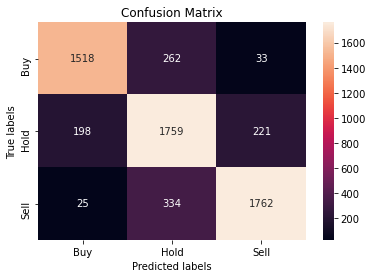

In [8]:
# Confusion Matrix

# Performance
y_pred=mlp_model_BTC.predict(X_test) 
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)

# Plotting Confusion Matrix
cm=confusion_matrix(y_test, y_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Buy', 'Hold', 'Sell']); ax.yaxis.set_ticklabels(['Buy', 'Hold', 'Sell']);

### Saving and Reloading the Model

In [41]:
# Saving the model

mlp_model.save('Models/MLP 1H BTC.h5')

In [4]:
# Reloading the model

mlp_model_BTC=model = keras.models.load_model('Models/MLP 1H BTC.h5')